In [8]:
#run presentation_funct.ipynb
#temp_model = model

/home/kondrat/.conda/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Sberbank Russian Housing Market 
Кондратенко Владимир, 477 группа

## Постановка задачи и доступные данные
- Были доступны некоторые характеристики квартир/домов  в Москве, такие как жилая площадь, количество этажей, материал стен, дата транзакции и другие.
- По известным характеристикам квартир/домов и ценам их продажи в период с августа 2011 года до июня 2015 требовалось предсказать цены продаж на тестовой выборке с июля 2015 по май 2016.
- Метрика качества - RMSLE (RMSE для логарифма цены)

## Предварительный анализ данных

In [2]:
print (train_df.shape)
print (test_df.shape)

(27232, 294)
(7662, 293)


### Типы данных

In [35]:
train_df.columns.tolist()

['id',
 'timestamp',
 'full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'product_type',
 'sub_area',
 'area_m',
 'raion_popul',
 'green_zone_part',
 'indust_part',
 'children_preschool',
 'preschool_quota',
 'preschool_education_centers_raion',
 'children_school',
 'school_quota',
 'school_education_centers_raion',
 'school_education_centers_top_20_raion',
 'hospital_beds_raion',
 'healthcare_centers_raion',
 'university_top_20_raion',
 'sport_objects_raion',
 'additional_education_raion',
 'culture_objects_top_25',
 'culture_objects_top_25_raion',
 'shopping_centers_raion',
 'office_raion',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'full_all',
 'male_f',
 'female_f',
 'young_all',
 'young_male',
 'young_female',
 'work_all',
 'work_male',
 'work_female',
 'ekder_all'

In [3]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,159
1,datetime64[ns],1
2,float64,119
3,object,15


### Пропущенные значения

/home/kondrat/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


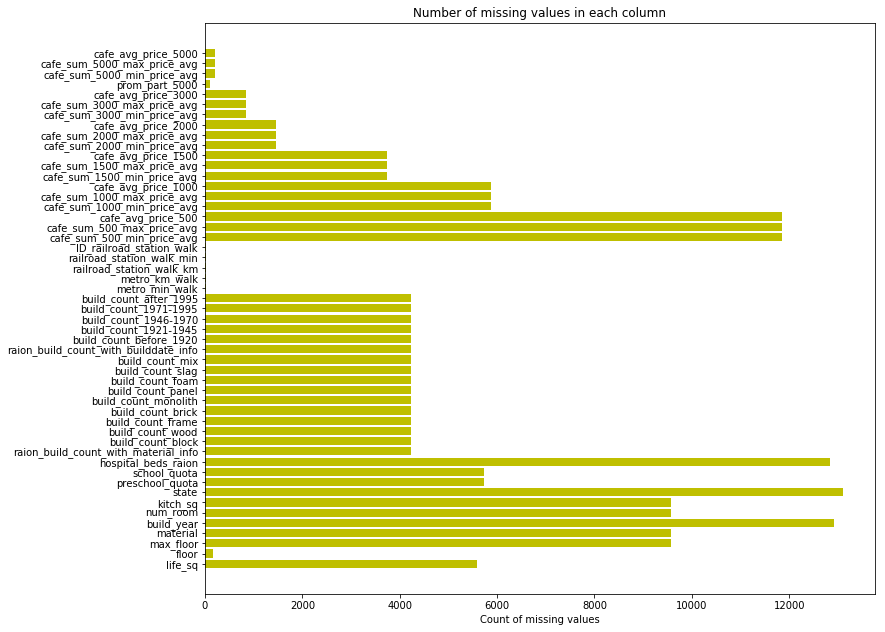

In [7]:
missing_data(train_df, size=(12,10.5))

/home/kondrat/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


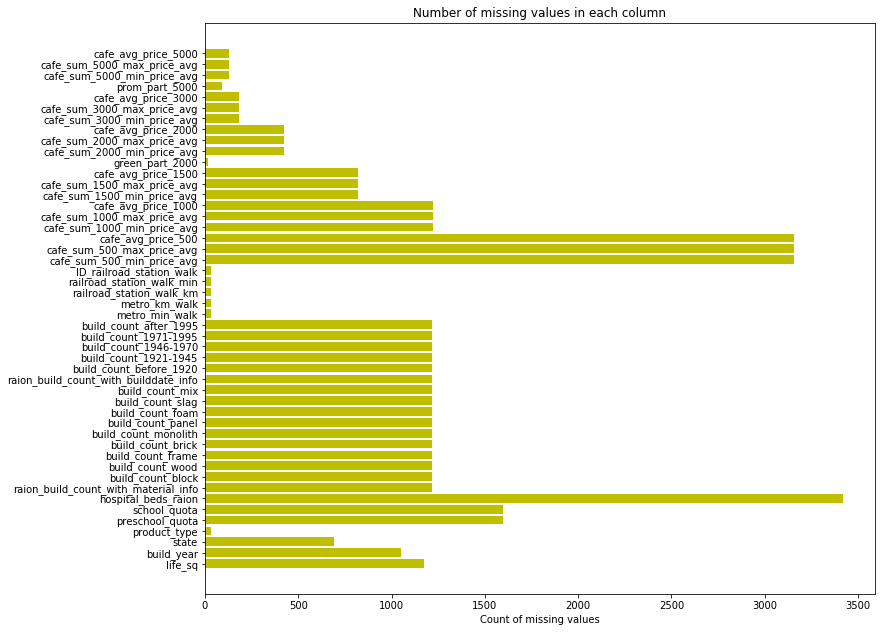

In [9]:
missing_data(test_df, size=(12,10.5))

### Распределение целевого признака

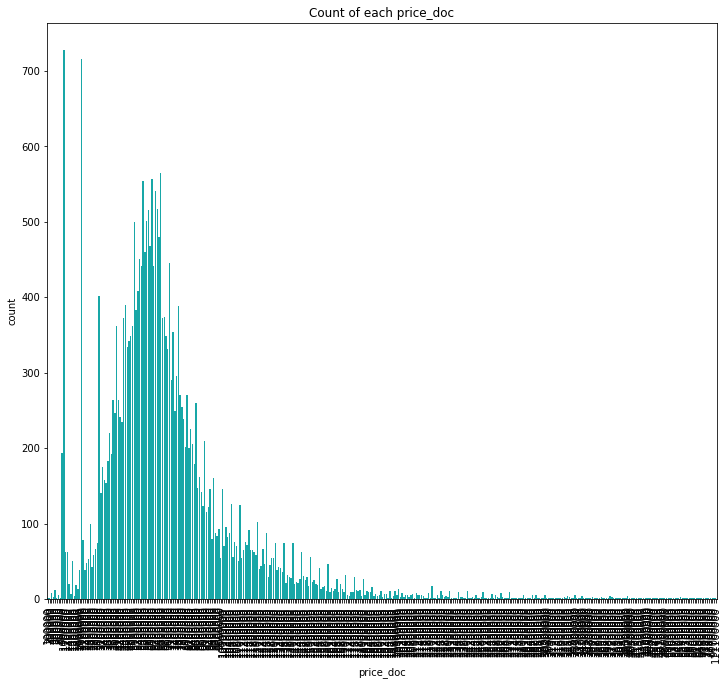

In [10]:
prices = graph_count((train_df[['price_doc']]/100000).astype(int)*100000, 'price_doc', size=(12,10.6))

In [11]:
prices[:5]

,price_doc,count
0,1000000,727
1,2000000,715
2,6500000,565
3,6000000,557
4,5500000,554


Довольно важными признаками, на мой взгляд, являются полная площадь квартиры, и район, в котором она расположена. Давайте взглянем на распределение этих признаков.

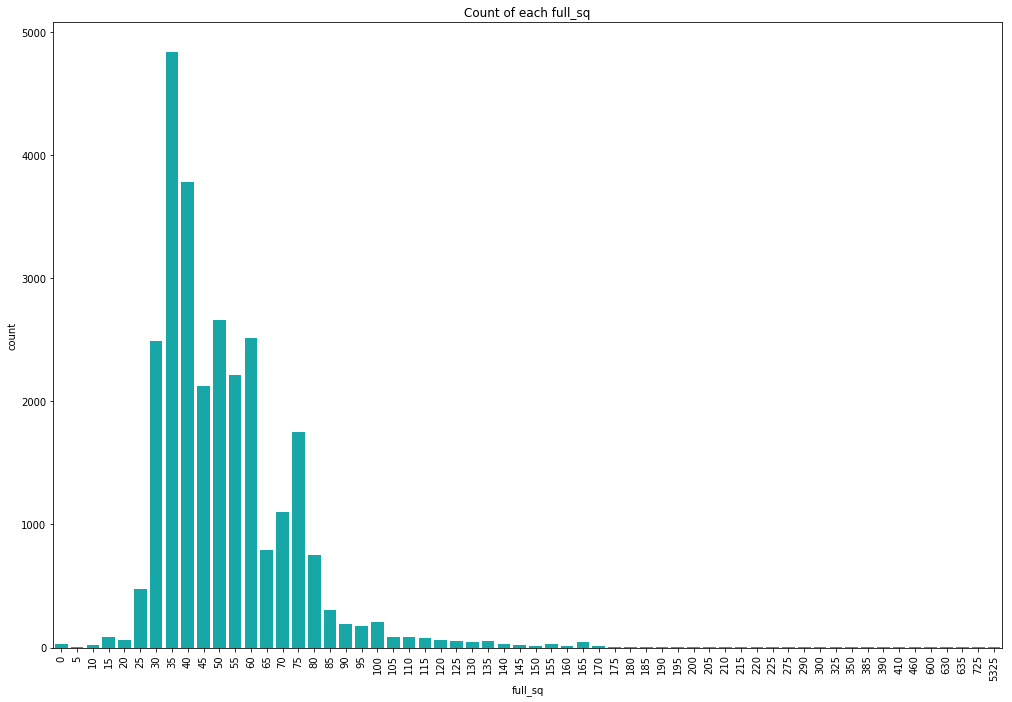

In [12]:
# train
full_sq_train = graph_count((train_df[['full_sq']]/5).astype(int)*5,feature ='full_sq',size=(17,11.5))

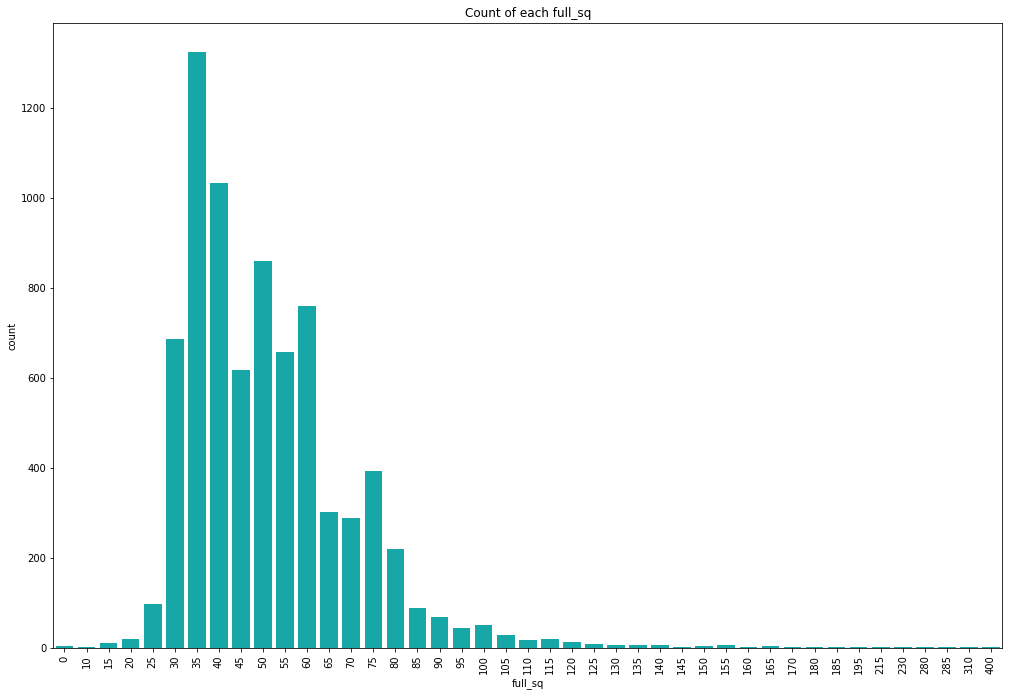

In [13]:
# test
full_sq_test = graph_count((test_df[['full_sq']]/5).astype(int)*5, 'full_sq', size=(17,11.5))

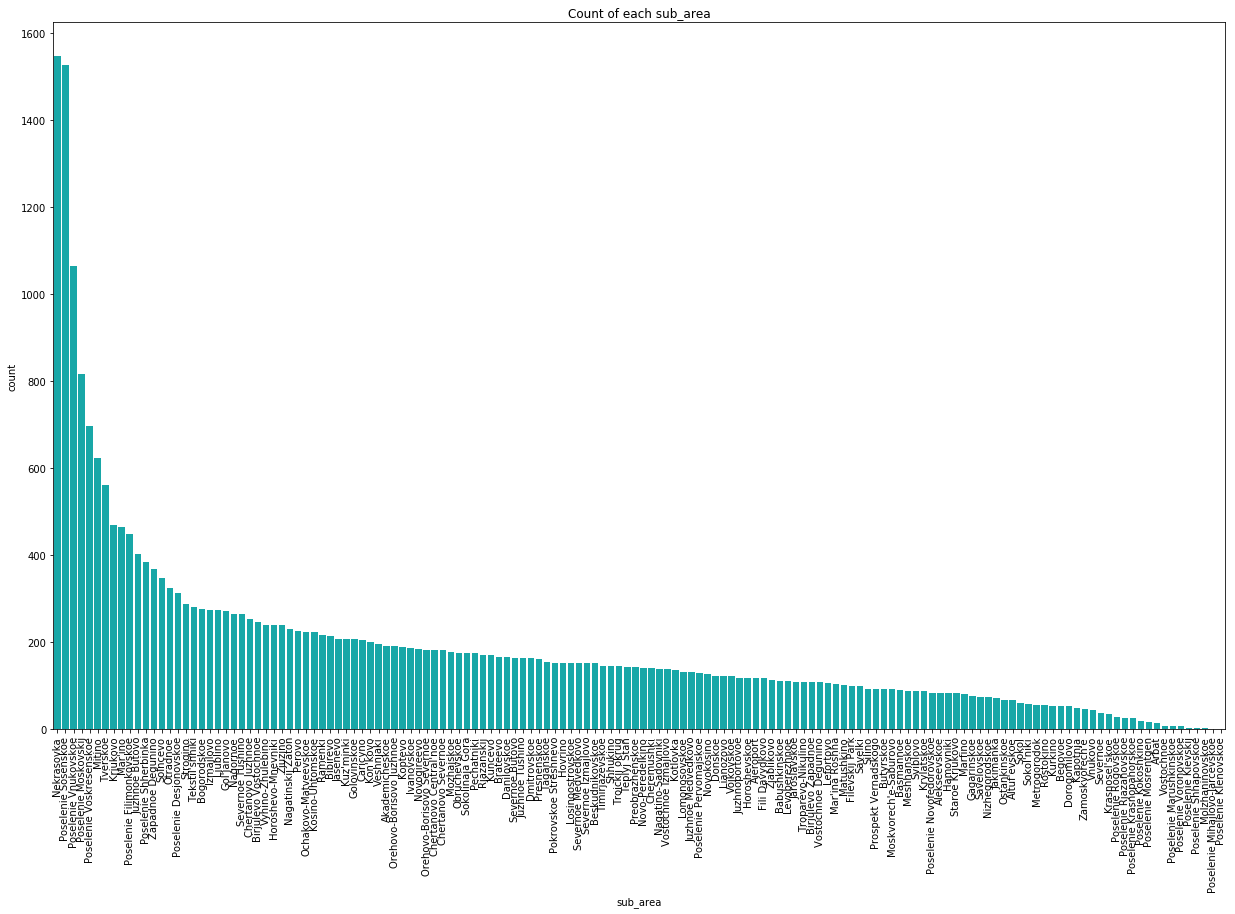

In [14]:
# train
sub_area_train = graph_count(train_df, 'sub_area', size=(21,13))

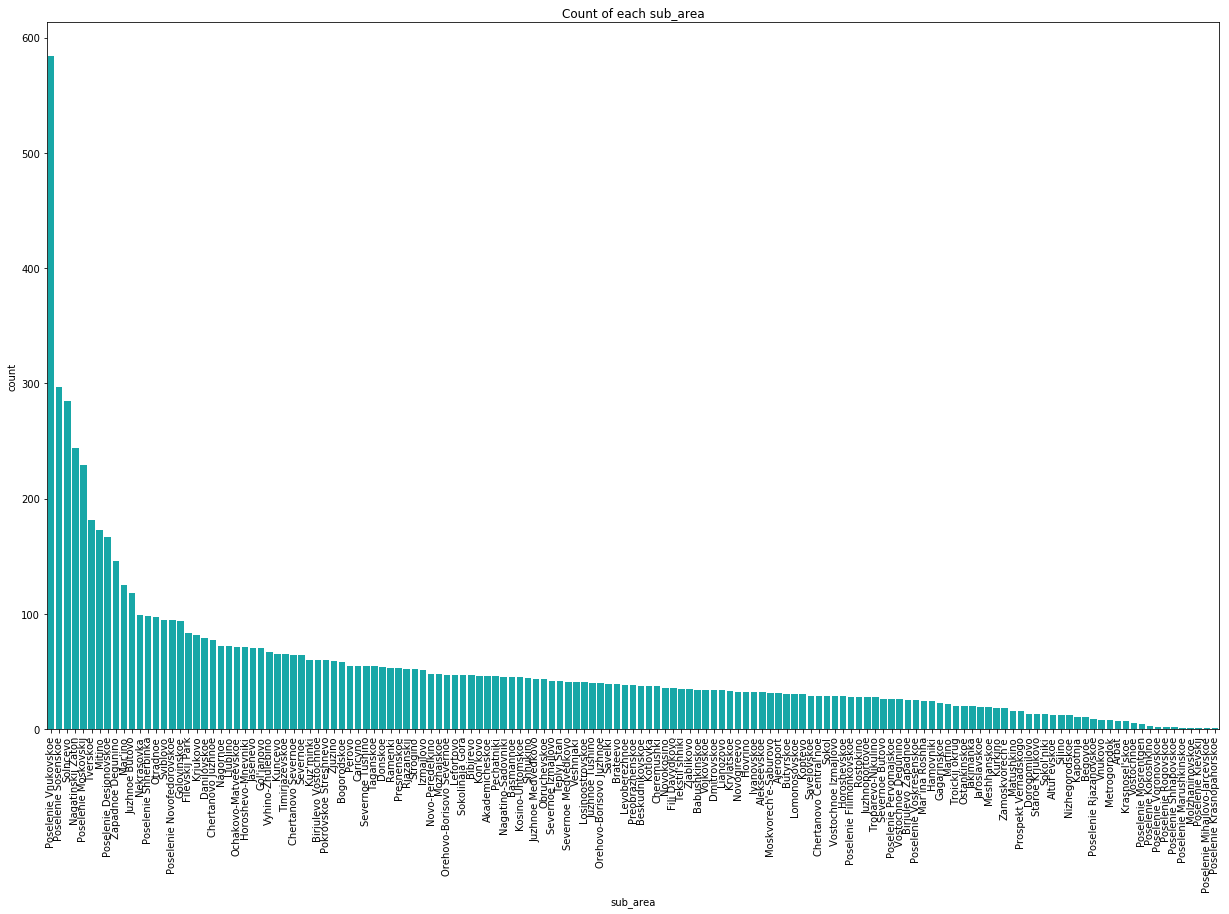

In [15]:
# test
sub_area_test = graph_count(test_df, 'sub_area', size=(21,13))

## Основные проблемы с данными

- Много пропущенных значений
- Выбросы в цене на уровне 1 и 2 млн рублей
- Часть данных некорректна

In [16]:
bad_data = (train_df['full_sq'] < train_df['life_sq']) |\
            ((train_df['full_sq'] < 15) | (train_df['full_sq'] > 600)) |\
            (train_df['max_floor'] < train_df['floor']) |\
            (train_df['build_year'] < 1147)|\
            (train_df['life_sq'] < 12) |\
            (train_df['full_sq'] < train_df['kitch_sq'])|\
            (train_df['kremlin_km'] < 0.2)
            

train_df[bad_data].shape[0]

2473

# Baseline
- Я пытался использовать 2 алгоритма: xgboost и random forest. Так как имеем довольно много категориальных признаков, в том числе и пропущеных
- Я пытался использовать 2 типа валидации: кросс валидацию (kfold) и разбивал выборку, сохраняя временную структуру (обучался по данным до 2015 года, тестировал по данным после 15 года). Второй способ давал score ближе к leaderboard, но первый лучше передавал корреляцию между улучшением на валидации и на тензорборде
- В качестве целевой переменной использовал цену или логарифм цены. В обоих случаях метрика качества была rmse, что предлагалось на kaggle.

Результаты оказались 0.332-0.333

В итоге я остановился на хgboost с добавлением временных признаков (см. baseline.ipynb)

Я пытался использовать и другие алгоритмы, но они довольно долго обучались + очевидно проирывали xgboost. В скором времени я понял, что нужно сделать основной упор на чистку данных и генерацию новых признаков, а остальное за меня сделает gridsearch по параметрам.

## Важность признаков

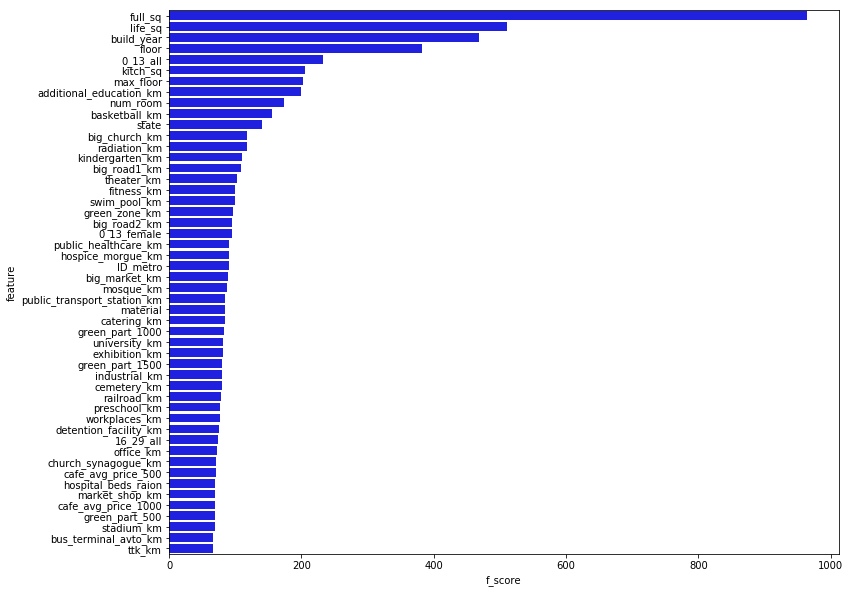

In [18]:
feature_importance(size = (12,10))

## Попытки решить проблемы с данными

### Часть данных некорректна

- В некоторых местах были перепутаны full_sq и life_sq или max_floor и floor
- Неадекватные значения (full_sq < 15, build_year < 1800, build_year > 2030, life_sq < 8 т. д.) заменялись на np.nan
- Ошибки в порядке решались делением на нужную степень десяти (full_sq = 520, life_sq = 40 --> full_sq = 52, life_sq = 40)
- Часть некорректных данных была исправлена организаторами (они выложили файл с исправленными данными)

### Попытка заполнить NaN'ы
- Я разбивал квартиры на маленькие группы, группируя по району и расстояниям ('sub_area', 'mkad_km','kremlin_km','ttk_km','sadovoe_km')$^{*}$ Внутри групп выделялись подгруппы, для каждой подгруппы я считал медиану/среднее заполняемого значения и заменяли им NaN'ы внутри подгруппы.
    - подгруппа с общим material и max_floor, заменяли build_year
    - подгруппа с общим build_year и max_floor, заменяли material

- Считалась среднее/медиану значение kitch_sq, life_sq среди квартир, с одинаковыми full_sq и заменяли им NaN'ы

$^*$ значения последних четырех признаков округлялись до 2 знака после запятой

### Борьба с выбросами в цене

Как было замечено ранее, значение цены 2 миллиона и 1 миллион очень популярно. Причём эта цена необоснованно низкая.

In [24]:
prices[:5]

,price_doc,count
0,1000000,727
1,2000000,715
2,6500000,565
3,6000000,557
4,5500000,554


In [25]:
train_df[((train_df['price_doc'] == 2000000) | (train_df['price_doc'] == 1000000) )]\
[['full_sq', 'life_sq','sub_area','price_doc']]

,full_sq,life_sq,sub_area,price_doc
7,44,44.0,Bibirevo,2000000
9,36,21.0,Kuncevo,2000000
39,33,18.0,Veshnjaki,2000000
50,51,33.0,Caricyno,1000000
56,56,39.0,Bogorodskoe,2000000
66,50,29.0,Strogino,1000000
68,76,45.0,Rostokino,2000000
80,47,31.0,Gol'janovo,1000000
82,34,19.0,Hovrino,1000000
107,74,43.0,Zapadnoe Degunino,1000000


Данная тема поднималась в обсуждениях на kaggle, где было выяснено, что люди специально занижают цену квартиры, чтобы не платить налоги. Так как налогами облагаются люди, владеющие квартрирой менее 3х лет.

Среди признаков был признак product_type: owner-occupier purchase or investment

In [27]:
train_df[((train_df['price_doc'] == 2000000) |\
          (train_df['price_doc'] == 1000000) )]\
    [['id','product_type']].groupby('product_type').count()

,id
product_type,
Investment,1384
OwnerOccupier,2


In [28]:
train_df[['id','product_type']].groupby('product_type').count()

,id
product_type,
Investment,17693
OwnerOccupier,9539


In [29]:
test_df[['id','product_type']].groupby('product_type').count()

,id
product_type,
Investment,4998
OwnerOccupier,2631


Я строил одну модель для предсказания цен для OwnerOccupier, а другую модель для предсказания цен Investment.

### Добавление новых признаков
В качестве новых признаков я добавлял:
- Месяц, год. Год*100+Месяц
- Квадраты расстояний ('mkad_km','kremlin_km' и т. д.)
- Среднюю площадь комнаты
- Разницу между max_floor и floor
- Разницу между year и build_year
- Микрорайон (sub_area + признаки "расстояний", как в заполнении NaN'ов)

## Финальная модель

Для предсказания цен квартир с product_type = Investment использовались предсказания baseline 
- с добавленными признаками year и month
- при этом некорректные данные никак не исправлялись
- предсказывалось price_doc
- ответ модели умножался на 0.97.

leaderboard: 0.31319

Для предсказания цен квартир с product_type = OwnerOccupier использовались предсказания модели из kaggle_final.ipynb:
- добавлялись признаки year и month и округляли "расстояния" до сотых
- исправлялись некорректные данные
- заполнениялись NaN'ы
    - build_year по микрорайонам
    - life_sq средним значением по full_sq
- использовались данные с тем же product_type
- предсказывался логарифм цены

leaderboard: 0.31261

Опимизация гиперпараметров алгоритмов производилась перебором (gridsearch) с использованием кросс валидации. Лучшие эксперименты я загружал на leaderboard.

## Анализ полученных результатов

- наибольший вклад в ошибку вносят данные с product_type = Investment (~8% уклоняются от налогов)
- полученный результат не сильно хуже top10 (на 0.00367) и даже top1 (на 0.01435)
- интуитивные представления о важности отдельных признаков подтвердились, так как качество предсказаний улучшилось после исправления ошибок в важных на мой взгляд признаках